# Import

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil

In [2]:
import windows_utils_hf as util
import helpers

In [3]:
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

In [5]:
from sklearn import metrics

# Load Data

In [6]:
repo_fp = Path('../data/')
noh_fp = repo_fp / 'NOH'

## NOH Data

In [7]:
noh_data = pd.read_csv('../metadata/NOH_image_dataset_2c.csv', index_col=0)
noh_data

,data,patient_id,img_id,label,dataset,img_path,filename,new_img_path,new_label
0,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082014.jpg,processed_img/NOH_122/IMG_20230228_082014.jpg,1
1,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082225.jpg,processed_img/NOH_122/IMG_20230228_082225.jpg,1
2,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082229.jpg,processed_img/NOH_122/IMG_20230228_082229.jpg,1
3,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_081641.jpg,processed_img/NOH_122/IMG_20230228_081641.jpg,1
4,NOH,122,NOH_122,4,train,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230228_082243.jpg,processed_img/NOH_122/IMG_20230228_082243.jpg,1
...,...,...,...,...,...,...,...,...,...
2043,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082639.jpg,processed_img/NOH_24/IMG_20230116_082639.jpg,1
2044,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082508.jpg,processed_img/NOH_24/IMG_20230116_082508.jpg,1
2045,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082541.jpg,processed_img/NOH_24/IMG_20230116_082541.jpg,1
2046,NOH,24,NOH_24,5,test,/content/drive/MyDrive/Colab Notebooks/AI4Thyr...,IMG_20230116_082615.jpg,processed_img/NOH_24/IMG_20230116_082615.jpg,1


# Stats

In [8]:
noh_data[['new_label']].value_counts().sort_index()

new_label
0             382
1            1666
Name: count, dtype: int64

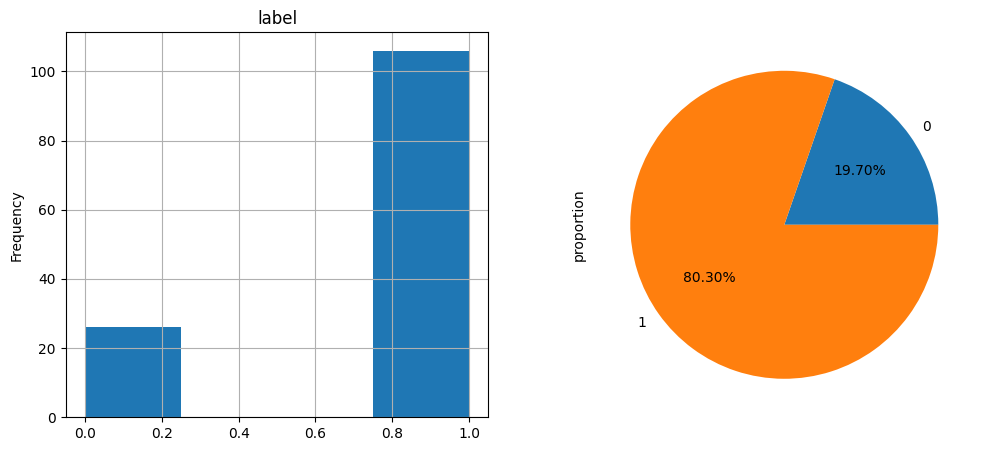

In [9]:
noh_sum = noh_data[['patient_id', 'new_label']].drop_duplicates()
fig, axs = plt.subplots(1,2,figsize=(12,5))
noh_sum['new_label'].plot(kind='hist', bins=4, title='label',ax=axs[0], grid=True)
noh_sum['new_label'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

## Per patient

In [10]:
noh_data.groupby(['dataset','new_label'])['patient_id'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='new_label', values='patient_id').astype(int)

new_label,0,1
dataset,,
test,7,32
train,11,45
val,8,29


## Per Image

In [11]:
noh_data.groupby(['dataset','new_label'])['filename'].nunique().to_frame().reset_index().pivot_table(index='dataset', columns='new_label', values='filename').astype(int)

new_label,0,1
dataset,,
test,104,540
train,158,673
val,120,453


In [12]:
img_ds = noh_data[['new_img_path', 'new_label', 'dataset']]
img_ds = img_ds.rename(columns={'new_img_path': 'img_path'})
img_ds['img_path'] = img_ds['img_path'].apply(lambda x: os.path.join(str(repo_fp), x.replace('./','')))
img_ds

,img_path,new_label,dataset
0,../data/processed_img/NOH_122/IMG_20230228_082...,1,train
1,../data/processed_img/NOH_122/IMG_20230228_082...,1,train
2,../data/processed_img/NOH_122/IMG_20230228_082...,1,train
3,../data/processed_img/NOH_122/IMG_20230228_081...,1,train
4,../data/processed_img/NOH_122/IMG_20230228_082...,1,train
...,...,...,...
2043,../data/processed_img/NOH_24/IMG_20230116_0826...,1,test
2044,../data/processed_img/NOH_24/IMG_20230116_0825...,1,test
2045,../data/processed_img/NOH_24/IMG_20230116_0825...,1,test
2046,../data/processed_img/NOH_24/IMG_20230116_0826...,1,test


## Transform

In [13]:
plt.rcParams["savefig.bbox"] = 'tight'

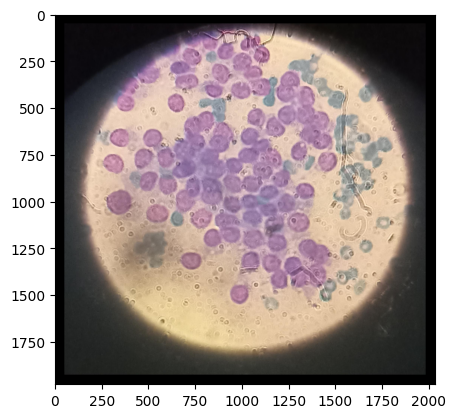

In [14]:
img_path = img_ds.iloc[0]['img_path']
# img = read_image(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [15]:
# prompt: generate train and test transform


# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.RandomCrop(224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Inspect train and test transform

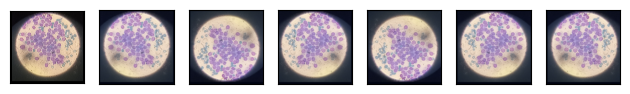

In [16]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [17]:
batch_size=32

# Dataset and DataLoader

In [18]:
# prompt: i need pytorch dataset that read from dataframe
class ThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['img_path'][idx]
        label = self.dataframe['new_label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [19]:
train_df = img_ds[img_ds['dataset']=='train'].reset_index(drop=True)
val_df = img_ds[img_ds['dataset']=='val'].reset_index(drop=True)
test_df = img_ds[img_ds['dataset']=='test'].reset_index(drop=True)

In [20]:
trainset = ThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [21]:
valset = ThyroidDataset(val_df, transform=test_transform)
valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

In [22]:
testset = ThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

##  Inspect Image

In [23]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

../data/processed_img/NOH_132/IMG_20230228_134505.jpg


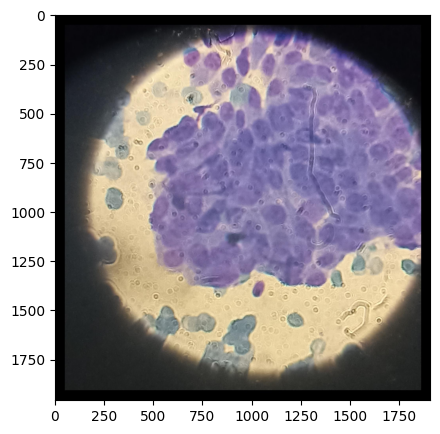

In [24]:
# Select a random item from the dataset
item_path = np.random.choice(train_df['img_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


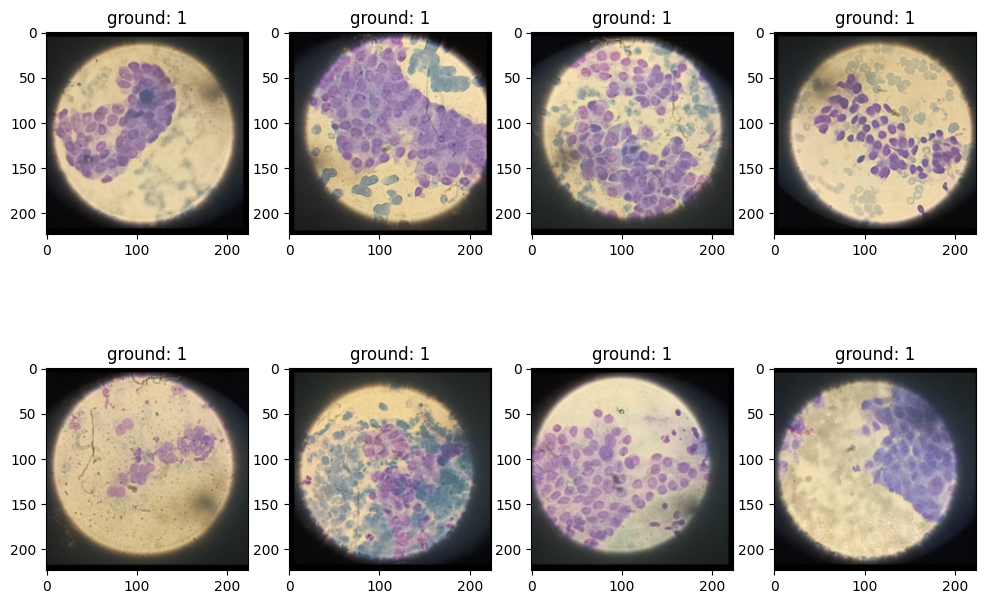

In [25]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [26]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB

GPU 1: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB



In [27]:
if num_gpus>1:
    device = device = torch.device("cuda")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../runs/thyroid_NOH_2c')

2024-02-18 19:23:20.538049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 19:23:20.538077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 19:23:20.539155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 19:23:20.544756: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 19:23:21.360270: W tensorflow/comp

# Load model

In [29]:
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [30]:
# change model output size
model._fc = nn.Linear(model._fc.in_features, train_df['new_label'].nunique())
model._fc

Linear(in_features=1280, out_features=2, bias=True)

In [31]:
model = nn.DataParallel(model)
model.to(device);

In [32]:
num_epochs = 15
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

In [34]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=num_epochs*len(trainloader))

In [35]:
def report_clf(preds_ts, outs_ts):
    np_preds = [i.numpy() for i in preds_ts]
    np_outs = [i.numpy() for i in outs_ts]
    
    np_preds = np.array([i for s in np_preds for i in s])
    np_outs = np.array([i for s in np_outs for i in s])
    assert np_preds.shape == np_outs.shape

    print(metrics.classification_report(np_outs, np_preds))

    cm = metrics.confusion_matrix(np_outs, np_preds)
    d = metrics.ConfusionMatrixDisplay(cm)
    d.plot()
    plt.show()

In [36]:
def evaluate_dataset(model, ds_loader):
    model.eval()
    loss = 0.0
    acc = 0.0
    preds = []
    outs = []
    for _, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
        preds.append(output.cpu().argmax(dim=1))
        outs.append(target.cpu())
        
    loss /= len(testloader)
    acc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    report_clf(preds, outs)
    return acc,preds, outs

# If exist model, then evaluate before write new

In [37]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2,3,4,5]
    with torch.no_grad():
        preds = model(test_features.to(device))
        #print(preds)
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

In [38]:
model_folder = '../model/NOH_2c/'
baseline_model_path = os.path.join(model_folder, 'efnb0_2c.pt')
if not os.path.exists(model_folder):
    os.makedirs(model_folder, exist_ok=True)

In [39]:
# reload model
model_fp = Path(baseline_model_path)
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc = evaluate_dataset(model, valoader)[0]
    run_predict_testset()

In [40]:
best_val_acc

0.0

# Train model

In [41]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [42]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [43]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

In [44]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        # target = target.clamp(min=0, max=5)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(valoader)):
        data, target = data.to(device), target.to(device)
        # target = target.clamp(min=0, max=5)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    val_loss /= len(valoader)
    val_acc /= len(valoader)

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(valoader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(valoader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), baseline_model_path)
        evaluate_dataset(model, testloader)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 0 	Train Loss: 0.3171 	Train Acc: 0.8665 	Val Loss: 0.9935 	Val Acc: 0.8218


  0%|          | 0/11 [00:00<?, ?it/s]

OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/efficientnet_pytorch/model.py", line 314, in forward
    x = self.extract_features(inputs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/efficientnet_pytorch/model.py", line 296, in extract_features
    x = block(x, drop_connect_rate=drop_connect_rate)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/efficientnet_pytorch/model.py", line 109, in forward
    x = self._depthwise_conv(x)
        ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/efficientnet_pytorch/utils.py", line 274, in forward
    x = self.static_padding(x)
        ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/torch/nn/modules/padding.py", line 205, in forward
    return F.pad(input, self.padding, 'constant', self.value)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacty of 7.79 GiB of which 26.50 MiB is free. Process 1733 has 112.68 MiB memory in use. Including non-PyTorch memory, this process has 7.64 GiB memory in use. Of the allocated memory 7.27 GiB is allocated by PyTorch, and 112.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [ ]:
best_val_acc

0.8524305555555556

# Evaluate

  0%|          | 0/41 [00:00<?, ?it/s]

Test Loss: 0.0000 	Test Acc: 0.7774
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.23      0.45      0.31        69
           2       0.92      0.86      0.89       540

    accuracy                           0.77       644
   macro avg       0.38      0.44      0.40       644
weighted avg       0.79      0.77      0.78       644



/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

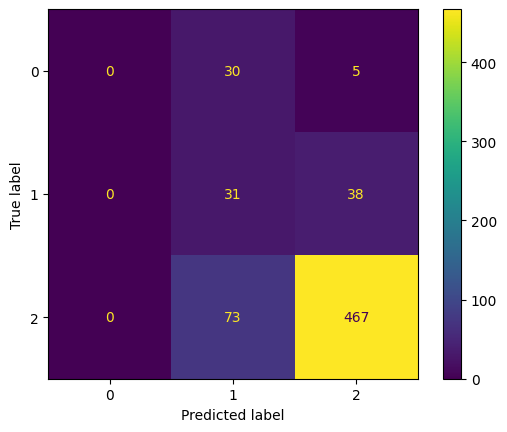

In [ ]:
p = evaluate_dataset(model, testloader)